In [1]:

import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.style
import matplotlib as mpl

import seaborn as sns
import numpy as np
from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

import queue as queue
import scipy.io as spio
from scipy.spatial import distance

### Lectura de datos

In [2]:
data= pd.read_csv('dataset_tissue.txt', sep=',')
clases = pd.read_csv('clase.txt', sep=',')
indexes = data.iloc[:,0]
data = data.iloc[:,1:]
data = data.set_index(np.array(indexes))
data.head(), data.shape

(           GSM11805.CEL.gz  GSM11814.CEL.gz  GSM11823.CEL.gz  GSM11830.CEL.gz  \
 1007_s_at        10.191267        10.509167        10.272027        10.252952   
 1053_at           6.040463         6.696075         6.144663         6.575153   
 117_at            7.447409         7.775354         7.696235         8.478135   
 121_at           12.025042        12.007817        11.633279        11.075286   
 1255_g_at         5.269269         5.180389         5.301714         5.372235   
 
            GSM12067.CEL.gz  GSM12075.CEL.gz  GSM12079.CEL.gz  GSM12098.CEL.gz  \
 1007_s_at        10.157605         9.966782         9.839348         9.945652   
 1053_at           6.606701         6.060069         6.186596         5.927861   
 117_at            8.116336         7.644452         8.009581         7.847192   
 121_at           10.832528        11.705062        11.706145        11.750370   
 1255_g_at         5.334905         5.253682         5.228794         5.155278   
 
            

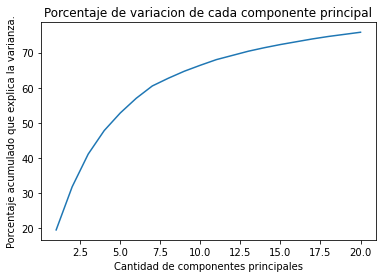

[ 19.5  31.8  41.1  47.8  52.8  57.   60.5  62.7  64.7  66.4  68.   69.2
  70.4  71.4  72.3  73.1  73.9  74.6  75.2  75.8  76.4  76.9  77.4  77.9
  78.4  78.8  79.2  79.6  80.   80.4  80.8  81.2  81.5  81.8  82.1  82.4
  82.7  83.   83.3  83.6  83.9  84.2  84.5  84.8  85.   85.2  85.4  85.6
  85.8  86.   86.2  86.4  86.6  86.8  87.   87.2  87.4  87.6  87.8  88.
  88.2  88.4  88.6  88.8  89.   89.2  89.4  89.6  89.8  90.   90.2  90.4
  90.6  90.8  91.   91.2  91.4  91.6  91.7  91.8  91.9  92.   92.1  92.2
  92.3  92.4  92.5  92.6  92.7  92.8  92.9  93.   93.1  93.2  93.3  93.4
  93.5  93.6  93.7  93.8  93.9  94.   94.1  94.2  94.3  94.4  94.5  94.6
  94.7  94.8  94.9  95.   95.1  95.2  95.3  95.4  95.5  95.6  95.7  95.8
  95.9  96.   96.1  96.2  96.3  96.4  96.5  96.6  96.7  96.8  96.9  97.
  97.1  97.2  97.3  97.4  97.5  97.6  97.7  97.8  97.9  98.   98.1  98.2
  98.3  98.4  98.5  98.6  98.7  98.8  98.9  99.   99.1  99.2  99.3  99.4
  99.5  99.6  99.7  99.8  99.9 100.  100.1 100.2 100.

In [3]:
data_escalada = preprocessing.scale(data.T)
pca = PCA()
pca.fit(data_escalada)
pca_data = pca.transform(data_escalada)
## Calculo del porcetaje de variacion que cada componente principal es responsable
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
acumulado = np.cumsum(per_var)
x=np.linspace(1,20,20)
y=acumulado[0:20]
plt.plot(x, y) 
plt.title('Porcentaje de variacion de cada componente principal')
plt.xlabel('Cantidad de componentes principales')
plt.ylabel('Porcentaje acumulado que explica la varianza.') 
plt.show()
print(acumulado)

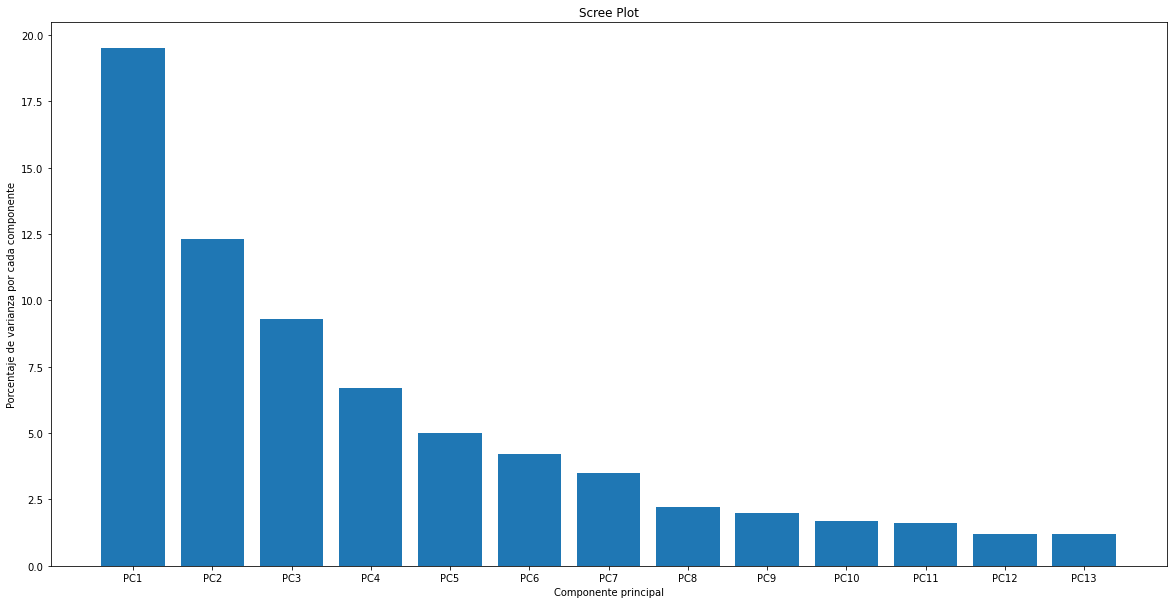

In [4]:
# etiquetas para cada componente principal
labels = ['PC' +str(x) for x in range(1, 14)] # len(per_var)+1
plt.figure(figsize=(20, 10))
plt.bar(x=range(1,14), height=per_var[0:13], tick_label=labels)
plt.ylabel('Porcentaje de varianza por cada componente')
plt.xlabel('Componente principal')
plt.title('Scree Plot')
plt.show()

In [5]:
#Creacion del dataframe con los componentes principales como features
labels = ['PC' +str(x) for x in range(1, len(per_var)+1)]
pca_df = pd.DataFrame(pca_data, index=np.array(data.columns),columns=labels)
df=pca_df.iloc[:,0:14]
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
GSM11805.CEL.gz,4.989192,-70.905965,26.739096,36.669324,36.458813,17.971833,-35.537055,11.247731,-1.613706,-20.799183,-40.101453,25.920407,-5.463506,1.970124
GSM11814.CEL.gz,23.059811,-72.898505,17.804589,23.514818,29.559735,18.287520,-24.667081,41.515795,-3.762307,-20.083933,9.361586,-20.827757,8.537856,29.846924
GSM11823.CEL.gz,36.557426,-18.220027,40.398095,21.642492,47.762464,15.946040,-52.113097,-25.187710,-1.493875,-46.392066,-10.207227,13.648709,7.362712,-7.009173
GSM11830.CEL.gz,62.805907,3.828831,19.596498,33.196816,72.890645,54.720863,-25.403626,56.563537,34.349584,6.630037,-3.777756,-4.713812,41.463246,-29.900075
GSM12067.CEL.gz,41.323546,-28.886986,23.183026,44.190248,67.024358,44.297101,-29.221301,53.406605,42.184078,16.119269,-20.012220,-4.996484,29.155295,-24.263857


## Implementación de K-Means

In [6]:
def kMeans(X,k):    
    j=0
    index = np.random.choice(X.shape[0], k, replace=False)
    cluster = np.zeros(X.shape[0])
    centroides = np.zeros((k, X.shape[1]))
    for i in index:
        centroides[j] = X[i]
        j+=1
    
    
    while True:
        for i, fila in enumerate(X):
            distancia = 9999999.0
                       
            # distancia del punto hasta los centroides
            for j, centroide in enumerate (centroides):
                #dist = np.sqrt((centroide[0]-fila[0])**2) ## + (centroide[1]-fila[1])**2)
                dist = np.linalg.norm(centroide-fila)
            
            # guardar distancia mas corta al centroide
                if distancia > dist:
                    distancia = dist
                    cluster[i] = j
        
        nuevosCentroides = pd.DataFrame(X).groupby(by=cluster).mean().values
        if np.count_nonzero(centroides-nuevosCentroides)==0:
            break
        else:
            centroides = nuevosCentroides
    return centroides, cluster 

## Implementacion de Gmm

In [7]:
def multivariate_normal(X, mean_vector, covariance_matrix):
    return (2*np.pi)**(-len(X)/2)*np.linalg.det(covariance_matrix)**(-1/2)*np.exp(-np.dot(np.dot((X-mean_vector).T, np.linalg.inv(covariance_matrix)), (X-mean_vector))/2)

def train_gmm(X, n_components, max_iter=100):
        comp_names=[]
        n_componets = n_components
        for i in range(n_components):
            comp_names.append(str(i))
        
        if comp_names == None:
            comp_names = [f"comp{index}" for index in range(n_componets)]
        else:
            comp_names = comp_names
        # pi list contains the fraction of the dataset for every cluster
        pi = [1/n_componets for comp in range(n_componets)]    
    

        
        new_X = np.array_split(X, n_componets)
        
        mean_vector = [np.mean(x, axis=0) for x in new_X]
        covariance_matrixes = [np.cov(x.T) for x in new_X]
        
        del new_X
        for iteration in range(max_iter):
            ''' --------------------------   E - STEP   -------------------------- '''
            r = np.zeros((len(X), n_componets))
            for n in range(len(X)):
                for k in range(n_componets):
                    r[n][k] = pi[k] * multivariate_normal(X[n], mean_vector[k], covariance_matrixes[k])
                    r[n][k] /= sum([pi[j]*multivariate_normal(X[n], mean_vector[j], covariance_matrixes[j]) for j in range(n_componets)])
            
            N = np.sum(r, axis=0)
            ''' --------------------------   M - STEP   -------------------------- '''
            
            mean_vector = np.zeros((n_componets, len(X[0])))
            
            for k in range(n_componets):
                for n in range(len(X)):
                    mean_vector[k] += r[n][k] * X[n]
            mean_vector = [1/N[k]*mean_vector[k] for k in range(n_componets)]
            
            covariance_matrixes = [np.zeros((len(X[0]), len(X[0]))) for k in range(n_componets)]
            
            for k in range(n_componets):
                covariance_matrixes[k] = np.cov(X.T, aweights=(r[:, k]), ddof=0)
            covariance_matrixes = [1/N[k]*covariance_matrixes[k] for k in range(n_componets)]
            
            pi = [N[k]/len(X) for k in range(n_componets)]

        probas = []
        for n in range(len(X)):
            probas.append([multivariate_normal(X[n], mean_vector[k], covariance_matrixes[k])
                           for k in range(n_componets)])
        cluster = []
        for proba in probas:
            cluster.append(comp_names[proba.index(max(proba))])
        return list(map(int, cluster))


## DBSCAN y HDBCSCAN

In [8]:
def algo_DBSCAN(X, clusters, eps, minPts, metric=distance.euclidean):

    #Itera sobre todos los veciunos de X y expande el cluse para cada punto que no sea ruido.

    currentPoint = 0
    
    for i in range(0, X.shape[0]):
        if clusters[i] != 0:
            continue
    
        neighbors = neighborsGen(X, i, eps, metric)

        if len(neighbors) < minPts:
            clusters[i] = -1

        else:
            currentPoint += 1
            expand(X, clusters, i, neighbors, currentPoint, eps, minPts, metric)
    
    return clusters

def neighborsGen(X, point, eps, metric):

    #Genera un vecindario para un punto dado.
    
    neighbors = []
    
    for i in range(X.shape[0]):
        if metric(X[point], X[i]) < eps:
            neighbors.append(i)
    
    return neighbors

def expand(X, clusters, point, neighbors, currentPoint, eps, minPts, metric):

    #Expande el cluster desde un punto dado hasta que se alcanza el borde del vecindario
    
    clusters[point] = currentPoint
    
    i = 0
    while i < len(neighbors):
        
        nextPoint = neighbors[i]
        
        if clusters[nextPoint] == -1:
            clusters[nextPoint] = currentPoint
        
        elif clusters[nextPoint] == 0:
            clusters[nextPoint] = currentPoint
            
            nextNeighbors = neighborsGen(X, nextPoint, eps, metric)
            
            if len(nextNeighbors) >= minPts:
                neighbors = neighbors + nextNeighbors
        
        i += 1

In [9]:
class DBSCAN:
    
    def __init__(self, eps, minPts, metric=distance.euclidean):
        self.eps = eps
        self.minPts = minPts
        self.metric = metric
    
    def fit_predict(self, X):
    
        clusters = [0] * X.shape[0]
        
        algo_DBSCAN(X, clusters, self.eps, self.minPts, self.metric)
        
        return clusters

In [32]:
scanner = DBSCAN(eps=0.3, minPts=5)

In [11]:
# Implementación de HDBSCAN algoritmo
def cluster_Hdbscan(df, min_cluster_size, min_samples):
    # Creación de un nuevo objeto hdbscan
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    # Ajustar el clúster a los datos
    clusterer.fit(df)
    # Obtener las etiquetas de los clústeres
    labels = clusterer.labels_
    return labels

## Aglomerative Clustering

In [12]:
# Uso de Agglomerative Clustering
def labels_AggloCluster(df, n_clusters):
    # Creación de un nuevo objeto AgglomerativeClustering
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # Ajustar el clúster a los datos
    clusterer.fit(df)
    # Get the cluster labels
    labels = clusterer.labels_
    return labels

In [13]:
# Plot dendogram
def plot_dendogram(model, **kwargs):

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    

    dendrogram(linkage_matrix, **kwargs)
    


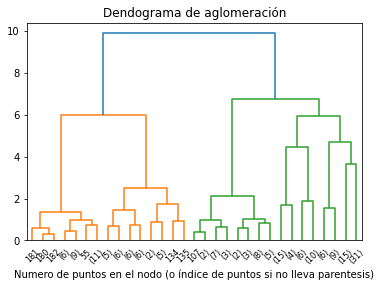

In [14]:
df_temp = np.array(df)
df_escalada = preprocessing.Normalizer().fit_transform(df_temp)
model = AgglomerativeClustering(n_clusters=None, linkage='ward',distance_threshold=0.5)
model.fit(df_escalada)
plt.title('Dendograma de aglomeración')
# Plot Top 4 niveles de aglomeración
plot_dendogram(model, truncate_mode='level', p=4)
plt.xlabel('Numero de puntos en el nodo (o índice de puntos si no lleva parentesis)')
plt.show()

# Pruebas de algoritmos

In [15]:
### Para los algoritmos de k-means y gmm se utilizaron 5,6,7 clústeres de prueba

In [16]:
def evaluarClusters(df,clases,n_clusters):
    np.random.seed(180)
    df_temp = np.array(df)
    df_escalada = preprocessing.Normalizer().fit_transform(df_temp)
    centroides, clusters_K_means = kMeans(df_escalada,n_clusters)
    clusters_Gaussian = train_gmm(np.array(df),n_clusters)
    #clusters_Gaussian = GaussianMixture(n_components=n_clusters, max_iter=100).fit(np.array(df)).predict(df)
    clusters_hdbscan = cluster_Hdbscan(df_escalada, 10, 5)
    clusters_dbscan = scanner.fit_predict(df_escalada)
    cluster_aglomerative = labels_AggloCluster(df_escalada,n_clusters)
    df1 =df.copy()
    df1['tejido'] = np.array(clases.x)
    df1['K-Mean-Cluster'] = clusters_K_means
    df1['GaussianMixture'] = clusters_Gaussian
    df1['DBSCAN'] = clusters_dbscan
    df1['HDBSCAN'] = clusters_hdbscan
    df1['Aglomerative'] = cluster_aglomerative
    df_kidney = df1[df1.tejido=='kidney']
    df_hippocampus = df1[df1.tejido=='hippocampus']
    df_cerebellum = df1[df1.tejido=='cerebellum']
    df_colon = df1[df1.tejido=='colon']
    df_liver = df1[df1.tejido=='liver']
    df_endometrium = df1[df1.tejido=='endometrium']
    df_placenta = df1[df1.tejido=='placenta']
    
    L = []
    L.append(df_kidney)
    L.append(df_hippocampus)
    L.append(df_cerebellum)
    L.append(df_colon)
    L.append(df_liver)
    L.append(df_endometrium)
    L.append(df_placenta)

    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(3, 2, 1,projection='3d')
    ax.scatter(df_kidney.PC1, df_kidney.PC2, df_kidney.PC3, marker='o', label='kidney',c='r')
    ax.scatter(df_hippocampus.PC1, df_hippocampus.PC2, df_hippocampus.PC3, marker='o', label='hippocampus',c='g')
    ax.scatter(df_colon.PC1, df_colon.PC2, df_colon.PC3, marker='o', label='colon',c='b')
    ax.scatter(df_cerebellum.PC1, df_cerebellum.PC2, df_cerebellum.PC3, marker='o', label='cerebellum',c='y')
    ax.scatter(df_liver.PC1, df_liver.PC2, df_liver.PC3, marker='o', label='liver',c='k')
    ax.scatter(df_endometrium.PC1, df_endometrium.PC2, df_endometrium.PC3, marker='o', label='endometrium',c='c')
    ax.scatter(df_placenta.PC1, df_placenta.PC2, df_placenta.PC3, marker='o', label='placenta',c='m')
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))
    plt.legend()

    ax = fig.add_subplot(3, 2, 2, projection='3d')
    scatter = ax.scatter(df1.PC1, df1.PC2, df1.PC3, marker='o', c=df1['GaussianMixture'], label=df1['tejido'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-GaussianMixture")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))

    ax = fig.add_subplot(3, 2, 3, projection='3d')
    scatter = ax.scatter(df1.PC1, df1.PC2, df1.PC3, marker='o', c=df1['K-Mean-Cluster'], label=df1['tejido'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-K means")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))

    ax = fig.add_subplot(3, 2, 4, projection='3d')
    scatter = ax.scatter(df1.PC1, df1.PC2, df1.PC3, marker='o', c=df1['DBSCAN'], label=df1['tejido'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-DBScan")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))
    
    ax = fig.add_subplot(3, 2, 5, projection='3d')
    scatter = ax.scatter(df1.PC1, df1.PC2, df1.PC3, marker='o', c=df1['HDBSCAN'], label=df1['tejido'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-HDBScan")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))    

    ax = fig.add_subplot(3, 2, 6, projection='3d')
    scatter = ax.scatter(df1.PC1, df1.PC2, df1.PC3, marker='o', c=df1['Aglomerative'], label=df1['tejido'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-Aglomerative")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))

    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(3, 2, 1)
    ax.scatter(df_kidney.PC1, df_kidney.PC2, marker='o', label='kidney',c='r')
    ax.scatter(df_hippocampus.PC1, df_hippocampus.PC2, marker='o', label='hippocampus',c='g')
    ax.scatter(df_colon.PC1, df_colon.PC2, marker='o', label='colon',c='b')
    ax.scatter(df_cerebellum.PC1, df_cerebellum.PC2, marker='o', label='cerebellum',c='y')
    ax.scatter(df_liver.PC1, df_liver.PC2, marker='o', label='liver',c='k')
    ax.scatter(df_endometrium.PC1, df_endometrium.PC2, marker='o', label='endometrium',c='c')
    ax.scatter(df_placenta.PC1, df_placenta.PC2, marker='o', label='placenta',c='m')

    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    plt.legend()

    ax = fig.add_subplot(3, 2, 2)
    scatter = ax.scatter(df1.PC1, df1.PC2, marker='o', c=df1['GaussianMixture'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-GaussianMixture")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))

    ax = fig.add_subplot(3, 2, 3)
    scatter = ax.scatter(df1.PC1, df1.PC2, marker='o', c=df1['K-Mean-Cluster'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-K means")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))

    ax = fig.add_subplot(3, 2, 4)
    scatter = ax.scatter(df1.PC1, df1.PC2, marker='o', c=df1['DBSCAN'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-DBScan")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    
    ax = fig.add_subplot(3, 2, 5)
    scatter = ax.scatter(df1.PC1, df1.PC2, marker='o', c=df1['HDBSCAN'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-HDBScan")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    
    ax = fig.add_subplot(3, 2, 6)
    scatter = ax.scatter(df1.PC1, df1.PC2, marker='o', c=df1['Aglomerative'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-Aglomerative")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))    
    
    plt.show()
    
    tejidos = np.unique(df1['tejido'])
    tipo_clusters = ['GaussianMixture', 'K-Mean-Cluster', 'DBSCAN', 'HDBSCAN', 'Aglomerative']
    resumen = pd.DataFrame(index = tejidos, columns = tipo_clusters)
    for i in tejidos:
        df_temp = df1[df1.tejido==i]
        total = df_temp.shape[0]
        for j in tipo_clusters:
            valores = np.unique(df_temp[j])
            l_temp = []
            for k in valores:
                porcentaje = df_temp[df_temp[j]==k][j].count()/total
                l_temp.append(porcentaje)
            float =max(l_temp)*100
            format_float = "{:.2f}".format(float)
            resumen.loc[i,j] = format_float
            percent = str(format_float) 
            print("Para el tejido " + i + " empleando " + j + " el " + percent + "% pertenece al mismo clúster") 
    
    
    return df1,resumen
    

In [17]:
def evaluarClusters2(df,clases,n_clusters):
    np.random.seed(180)
    df_temp = np.array(df)
    df_escalada = preprocessing.Normalizer().fit_transform(df_temp)
    centroides, clusters_K_means = kMeans(df_escalada,n_clusters)
    #clusters_Gaussian = train_gmm(np.array(df),n_clusters)
    clusters_Gaussian = GaussianMixture(n_components=n_clusters, max_iter=100).fit(np.array(df)).predict(df)
    clusters_hdbscan = cluster_Hdbscan(df_escalada, 10, 5)
    clusters_dbscan = scanner.fit_predict(df_escalada)
    cluster_aglomerative = labels_AggloCluster(df_escalada,n_clusters)
    df1 =df.copy()
    df1['tejido'] = np.array(clases.x)
    df1['K-Mean-Cluster'] = clusters_K_means
    df1['GaussianMixture'] = clusters_Gaussian
    df1['DBSCAN'] = clusters_dbscan
    df1['HDBSCAN'] = clusters_hdbscan
    df1['Aglomerative'] = cluster_aglomerative
    df_kidney = df1[df1.tejido=='kidney']
    df_hippocampus = df1[df1.tejido=='hippocampus']
    df_cerebellum = df1[df1.tejido=='cerebellum']
    df_colon = df1[df1.tejido=='colon']
    df_liver = df1[df1.tejido=='liver']
    df_endometrium = df1[df1.tejido=='endometrium']
    df_placenta = df1[df1.tejido=='placenta']
    
    L = []
    L.append(df_kidney)
    L.append(df_hippocampus)
    L.append(df_cerebellum)
    L.append(df_colon)
    L.append(df_liver)
    L.append(df_endometrium)
    L.append(df_placenta)

    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(3, 2, 1,projection='3d')
    ax.scatter(df_kidney.PC1, df_kidney.PC2, df_kidney.PC3, marker='o', label='kidney',c='r')
    ax.scatter(df_hippocampus.PC1, df_hippocampus.PC2, df_hippocampus.PC3, marker='o', label='hippocampus',c='g')
    ax.scatter(df_colon.PC1, df_colon.PC2, df_colon.PC3, marker='o', label='colon',c='b')
    ax.scatter(df_cerebellum.PC1, df_cerebellum.PC2, df_cerebellum.PC3, marker='o', label='cerebellum',c='y')
    ax.scatter(df_liver.PC1, df_liver.PC2, df_liver.PC3, marker='o', label='liver',c='k')
    ax.scatter(df_endometrium.PC1, df_endometrium.PC2, df_endometrium.PC3, marker='o', label='endometrium',c='c')
    ax.scatter(df_placenta.PC1, df_placenta.PC2, df_placenta.PC3, marker='o', label='placenta',c='m')
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))
    plt.legend()

    ax = fig.add_subplot(3, 2, 2, projection='3d')
    scatter = ax.scatter(df1.PC1, df1.PC2, df1.PC3, marker='o', c=df1['GaussianMixture'], label=df1['tejido'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-GaussianMixture")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))

    ax = fig.add_subplot(3, 2, 3, projection='3d')
    scatter = ax.scatter(df1.PC1, df1.PC2, df1.PC3, marker='o', c=df1['K-Mean-Cluster'], label=df1['tejido'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-K means")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))

    ax = fig.add_subplot(3, 2, 4, projection='3d')
    scatter = ax.scatter(df1.PC1, df1.PC2, df1.PC3, marker='o', c=df1['DBSCAN'], label=df1['tejido'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-DBScan")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))
    
    ax = fig.add_subplot(3, 2, 5, projection='3d')
    scatter = ax.scatter(df1.PC1, df1.PC2, df1.PC3, marker='o', c=df1['HDBSCAN'], label=df1['tejido'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-HDBScan")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))    

    ax = fig.add_subplot(3, 2, 6, projection='3d')
    scatter = ax.scatter(df1.PC1, df1.PC2, df1.PC3, marker='o', c=df1['Aglomerative'], label=df1['tejido'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-Aglomerative")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    ax.set_zlabel('PC3 - {0}%'.format(per_var[2]))

    fig = plt.figure(figsize=(25,25))
    ax = fig.add_subplot(3, 2, 1)
    ax.scatter(df_kidney.PC1, df_kidney.PC2, marker='o', label='kidney',c='r')
    ax.scatter(df_hippocampus.PC1, df_hippocampus.PC2, marker='o', label='hippocampus',c='g')
    ax.scatter(df_colon.PC1, df_colon.PC2, marker='o', label='colon',c='b')
    ax.scatter(df_cerebellum.PC1, df_cerebellum.PC2, marker='o', label='cerebellum',c='y')
    ax.scatter(df_liver.PC1, df_liver.PC2, marker='o', label='liver',c='k')
    ax.scatter(df_endometrium.PC1, df_endometrium.PC2, marker='o', label='endometrium',c='c')
    ax.scatter(df_placenta.PC1, df_placenta.PC2, marker='o', label='placenta',c='m')

    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    plt.legend()

    ax = fig.add_subplot(3, 2, 2)
    scatter = ax.scatter(df1.PC1, df1.PC2, marker='o', c=df1['GaussianMixture'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-GaussianMixture")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))

    ax = fig.add_subplot(3, 2, 3)
    scatter = ax.scatter(df1.PC1, df1.PC2, marker='o', c=df1['K-Mean-Cluster'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-K means")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))

    ax = fig.add_subplot(3, 2, 4)
    scatter = ax.scatter(df1.PC1, df1.PC2, marker='o', c=df1['DBSCAN'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-DBScan")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    
    ax = fig.add_subplot(3, 2, 5)
    scatter = ax.scatter(df1.PC1, df1.PC2, marker='o', c=df1['HDBSCAN'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-HDBScan")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))
    
    ax = fig.add_subplot(3, 2, 6)
    scatter = ax.scatter(df1.PC1, df1.PC2, marker='o', c=df1['Aglomerative'])
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left", title="Clusters-Aglomerative")
    ax.add_artist(legend1)
    ax.set_xlabel('PC1 - {0}%'.format(per_var[0]))
    ax.set_ylabel('PC2 - {0}%'.format(per_var[1]))    
    
    plt.show()
    
    tejidos = np.unique(df1['tejido'])
    tipo_clusters = ['GaussianMixture', 'K-Mean-Cluster', 'DBSCAN', 'HDBSCAN', 'Aglomerative']
    resumen = pd.DataFrame(index = tejidos, columns = tipo_clusters)
    for i in tejidos:
        df_temp = df1[df1.tejido==i]
        total = df_temp.shape[0]
        for j in tipo_clusters:
            valores = np.unique(df_temp[j])
            l_temp = []
            for k in valores:
                porcentaje = df_temp[df_temp[j]==k][j].count()/total
                l_temp.append(porcentaje)
            float =max(l_temp)*100
            format_float = "{:.2f}".format(float)
            resumen.loc[i,j] = format_float
            percent = str(format_float) 
            print("Para el tejido " + i + " empleando " + j + " el " + percent + "% pertenece al mismo clúster") 
    
    
    return df1,resumen
    

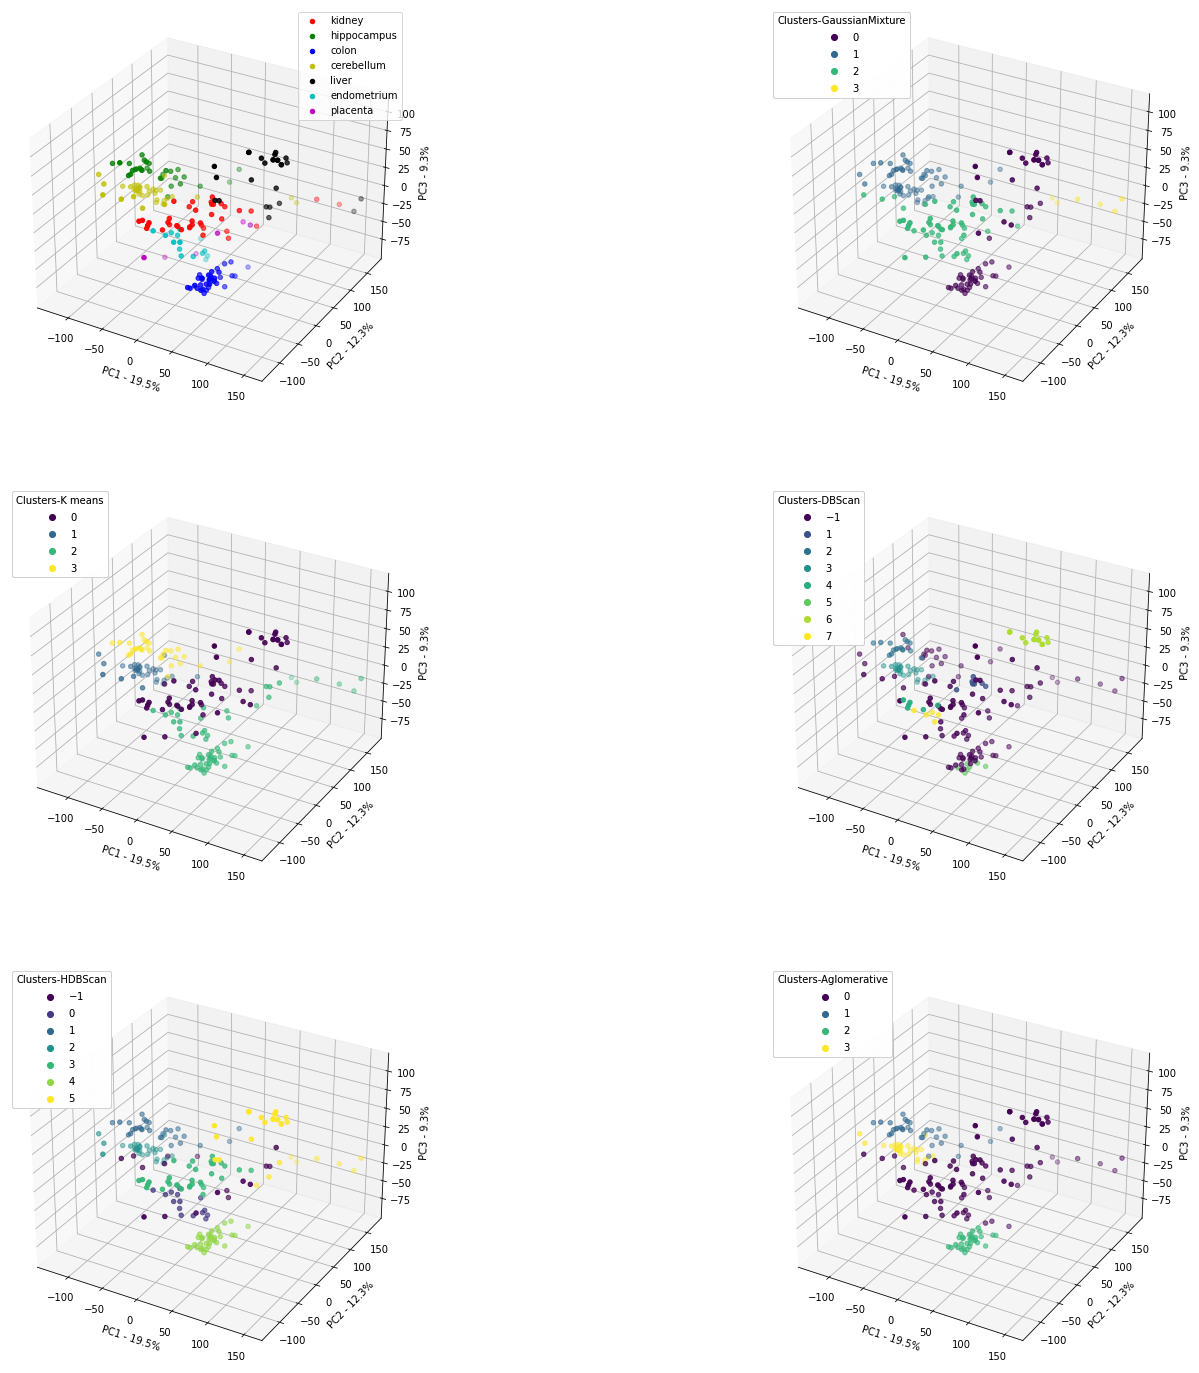

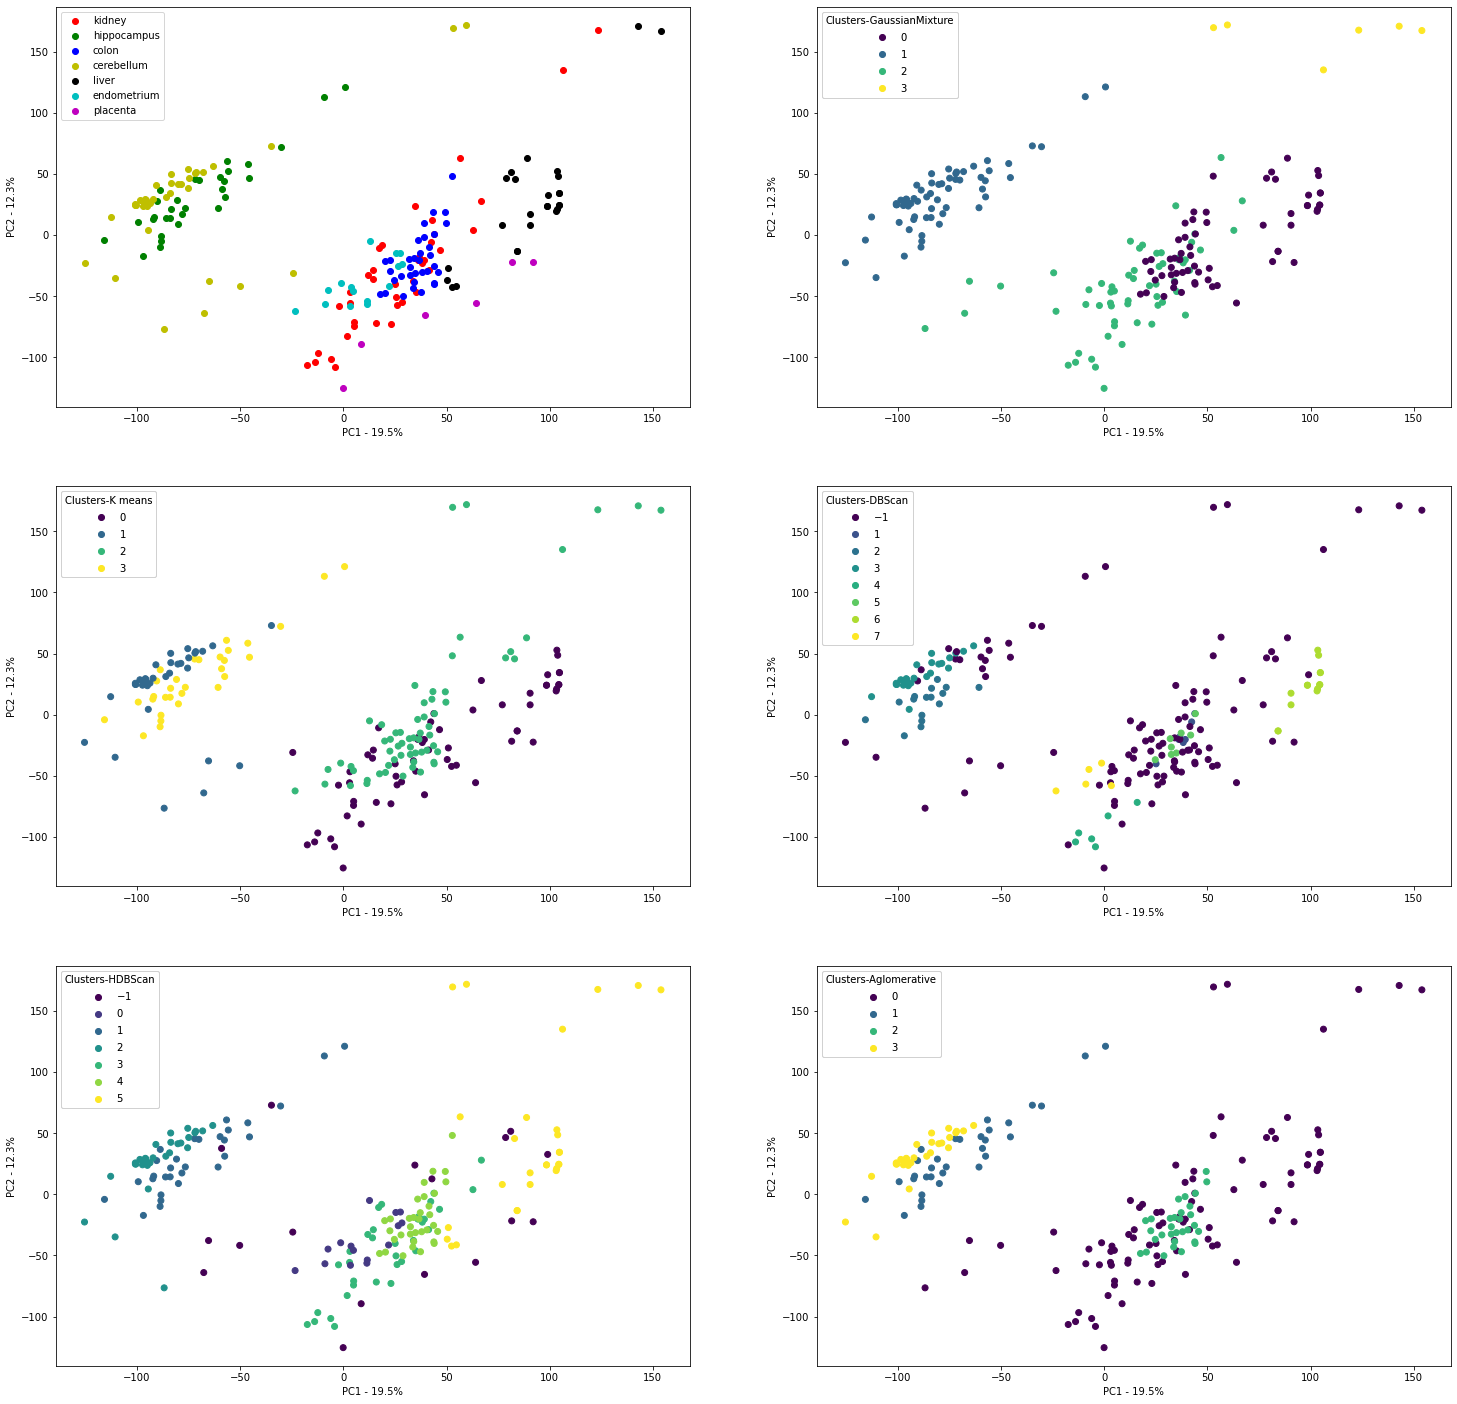

Para el tejido cerebellum empleando GaussianMixture el 81.58% pertenece al mismo clúster
Para el tejido cerebellum empleando K-Mean-Cluster el 92.11% pertenece al mismo clúster
Para el tejido cerebellum empleando DBSCAN el 68.42% pertenece al mismo clúster
Para el tejido cerebellum empleando HDBSCAN el 81.58% pertenece al mismo clúster
Para el tejido cerebellum empleando Aglomerative el 78.95% pertenece al mismo clúster
Para el tejido colon empleando GaussianMixture el 100.00% pertenece al mismo clúster
Para el tejido colon empleando K-Mean-Cluster el 100.00% pertenece al mismo clúster
Para el tejido colon empleando DBSCAN el 76.47% pertenece al mismo clúster
Para el tejido colon empleando HDBSCAN el 100.00% pertenece al mismo clúster
Para el tejido colon empleando Aglomerative el 91.18% pertenece al mismo clúster
Para el tejido endometrium empleando GaussianMixture el 100.00% pertenece al mismo clúster
Para el tejido endometrium empleando K-Mean-Cluster el 100.00% pertenece al mismo c

In [18]:
df4,resumen4=evaluarClusters2(df,clases,4)

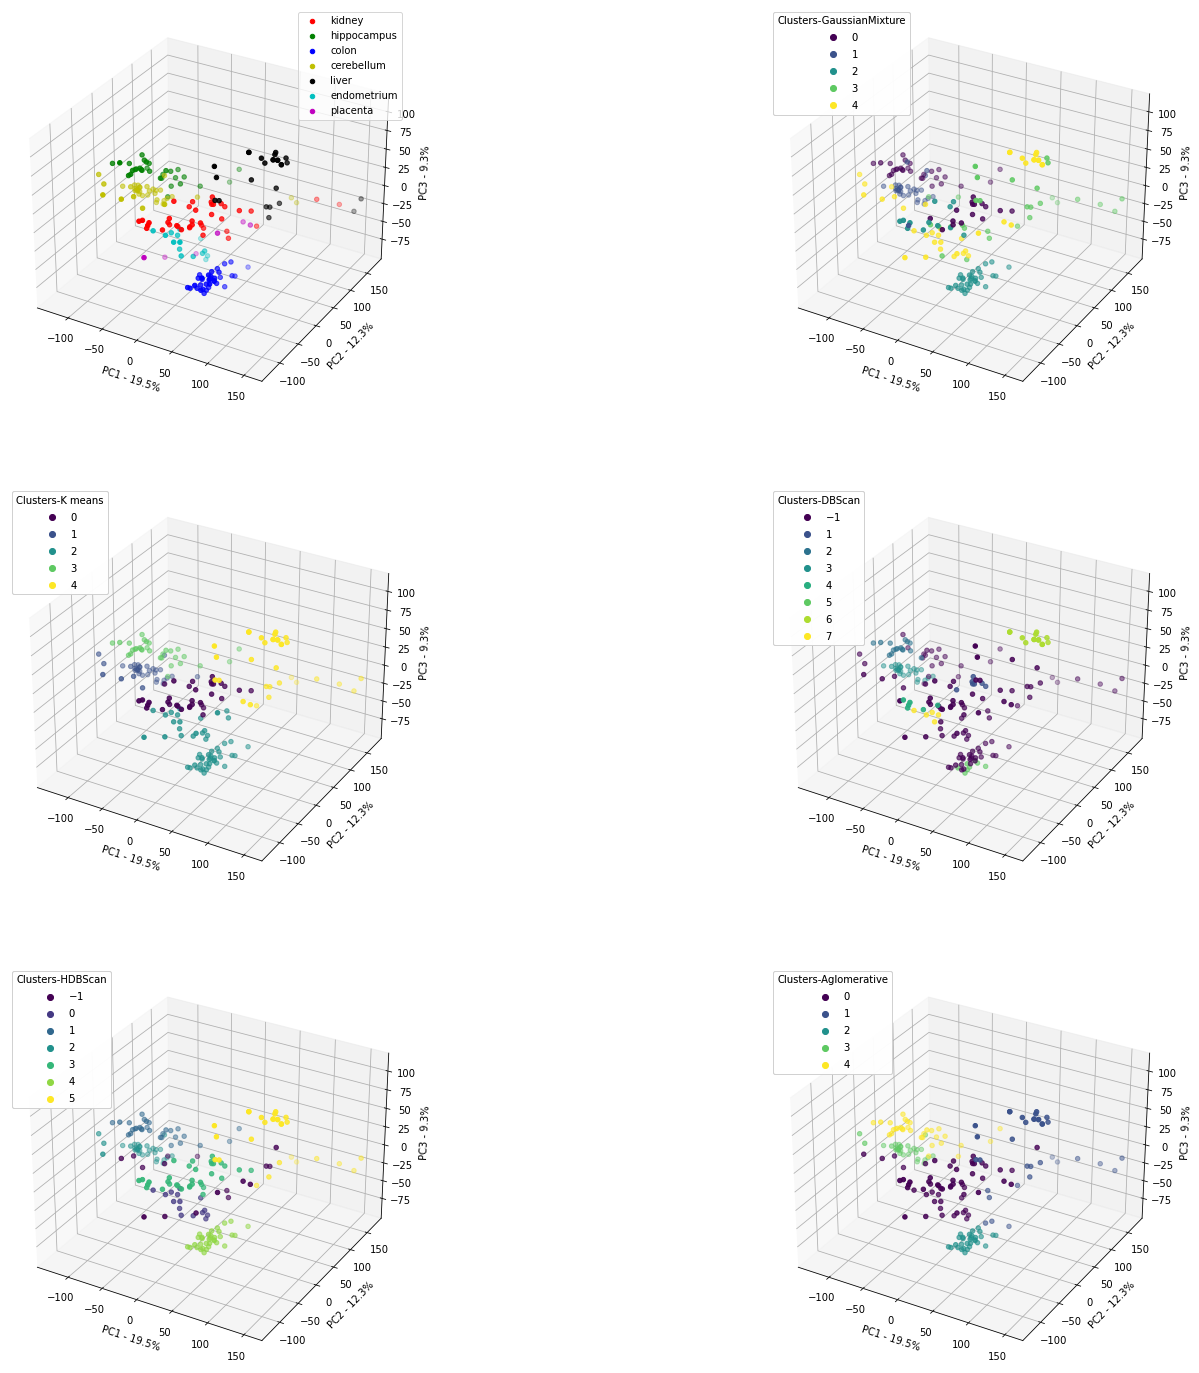

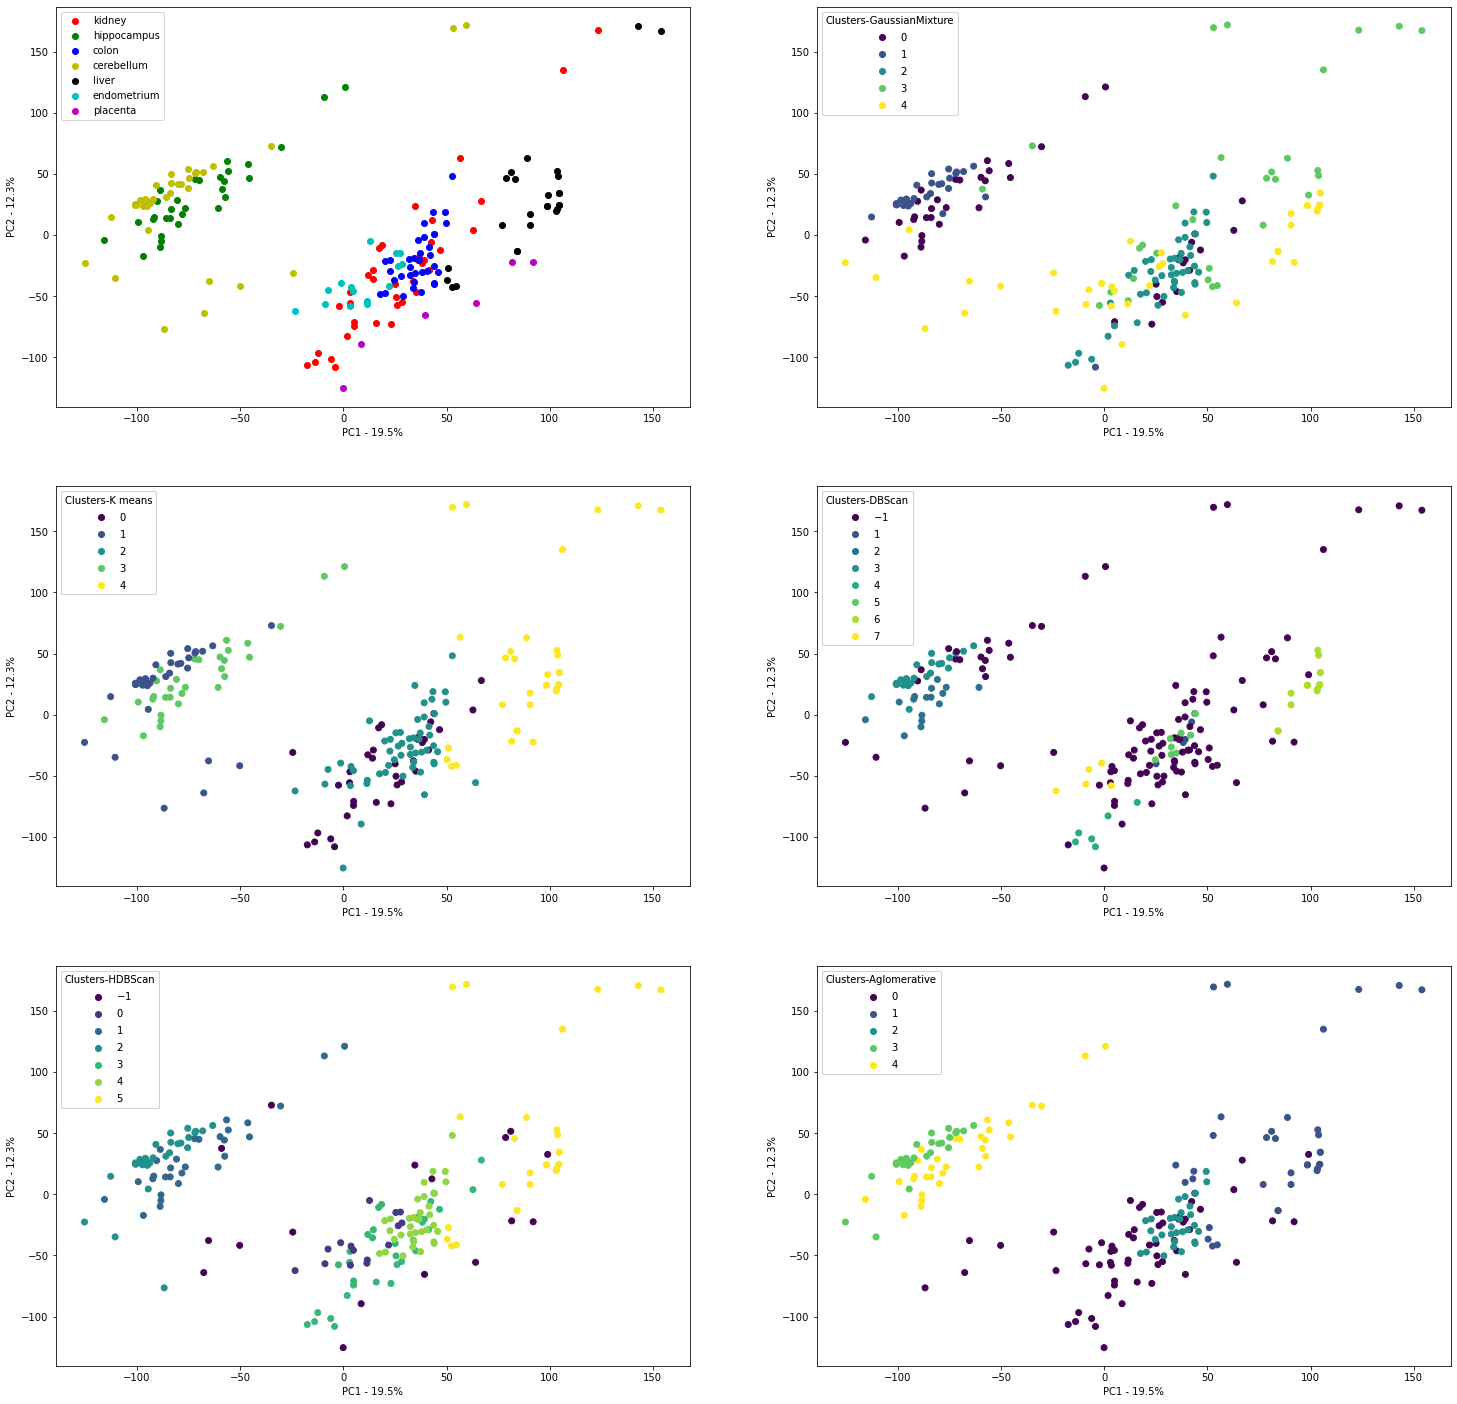

Para el tejido cerebellum empleando GaussianMixture el 71.05% pertenece al mismo clúster
Para el tejido cerebellum empleando K-Mean-Cluster el 92.11% pertenece al mismo clúster
Para el tejido cerebellum empleando DBSCAN el 68.42% pertenece al mismo clúster
Para el tejido cerebellum empleando HDBSCAN el 81.58% pertenece al mismo clúster
Para el tejido cerebellum empleando Aglomerative el 78.95% pertenece al mismo clúster
Para el tejido colon empleando GaussianMixture el 100.00% pertenece al mismo clúster
Para el tejido colon empleando K-Mean-Cluster el 100.00% pertenece al mismo clúster
Para el tejido colon empleando DBSCAN el 76.47% pertenece al mismo clúster
Para el tejido colon empleando HDBSCAN el 100.00% pertenece al mismo clúster
Para el tejido colon empleando Aglomerative el 91.18% pertenece al mismo clúster
Para el tejido endometrium empleando GaussianMixture el 86.67% pertenece al mismo clúster
Para el tejido endometrium empleando K-Mean-Cluster el 100.00% pertenece al mismo cl

In [19]:
df5,resumen5=evaluarClusters(df,clases,5)

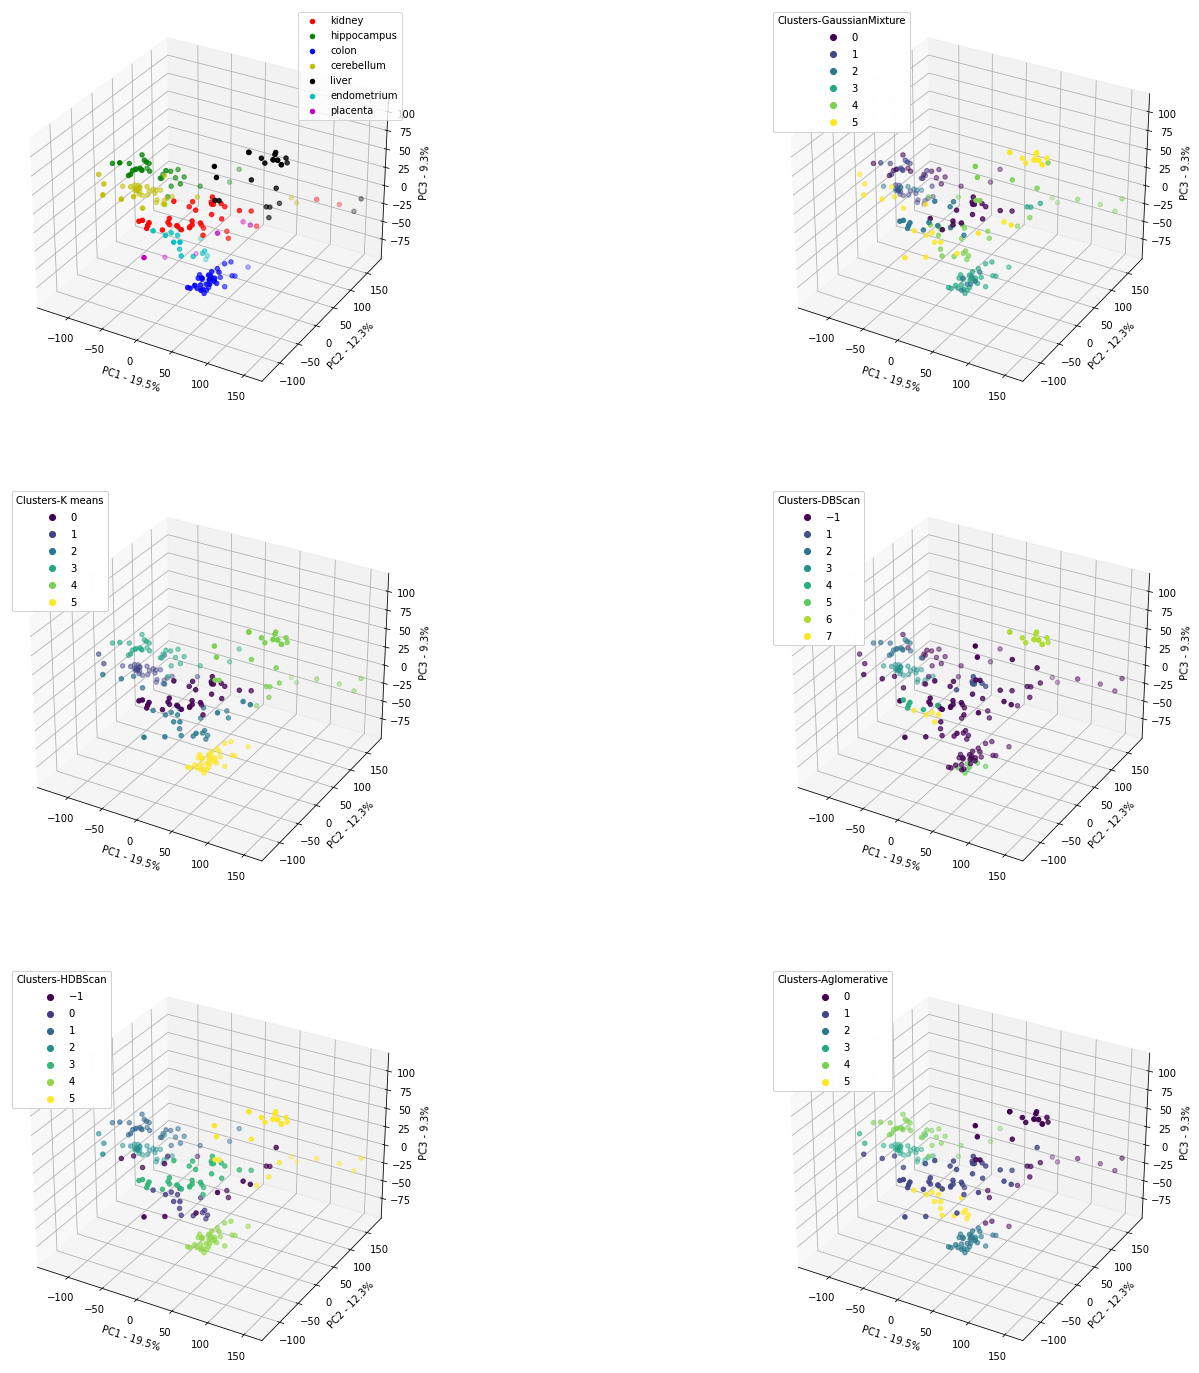

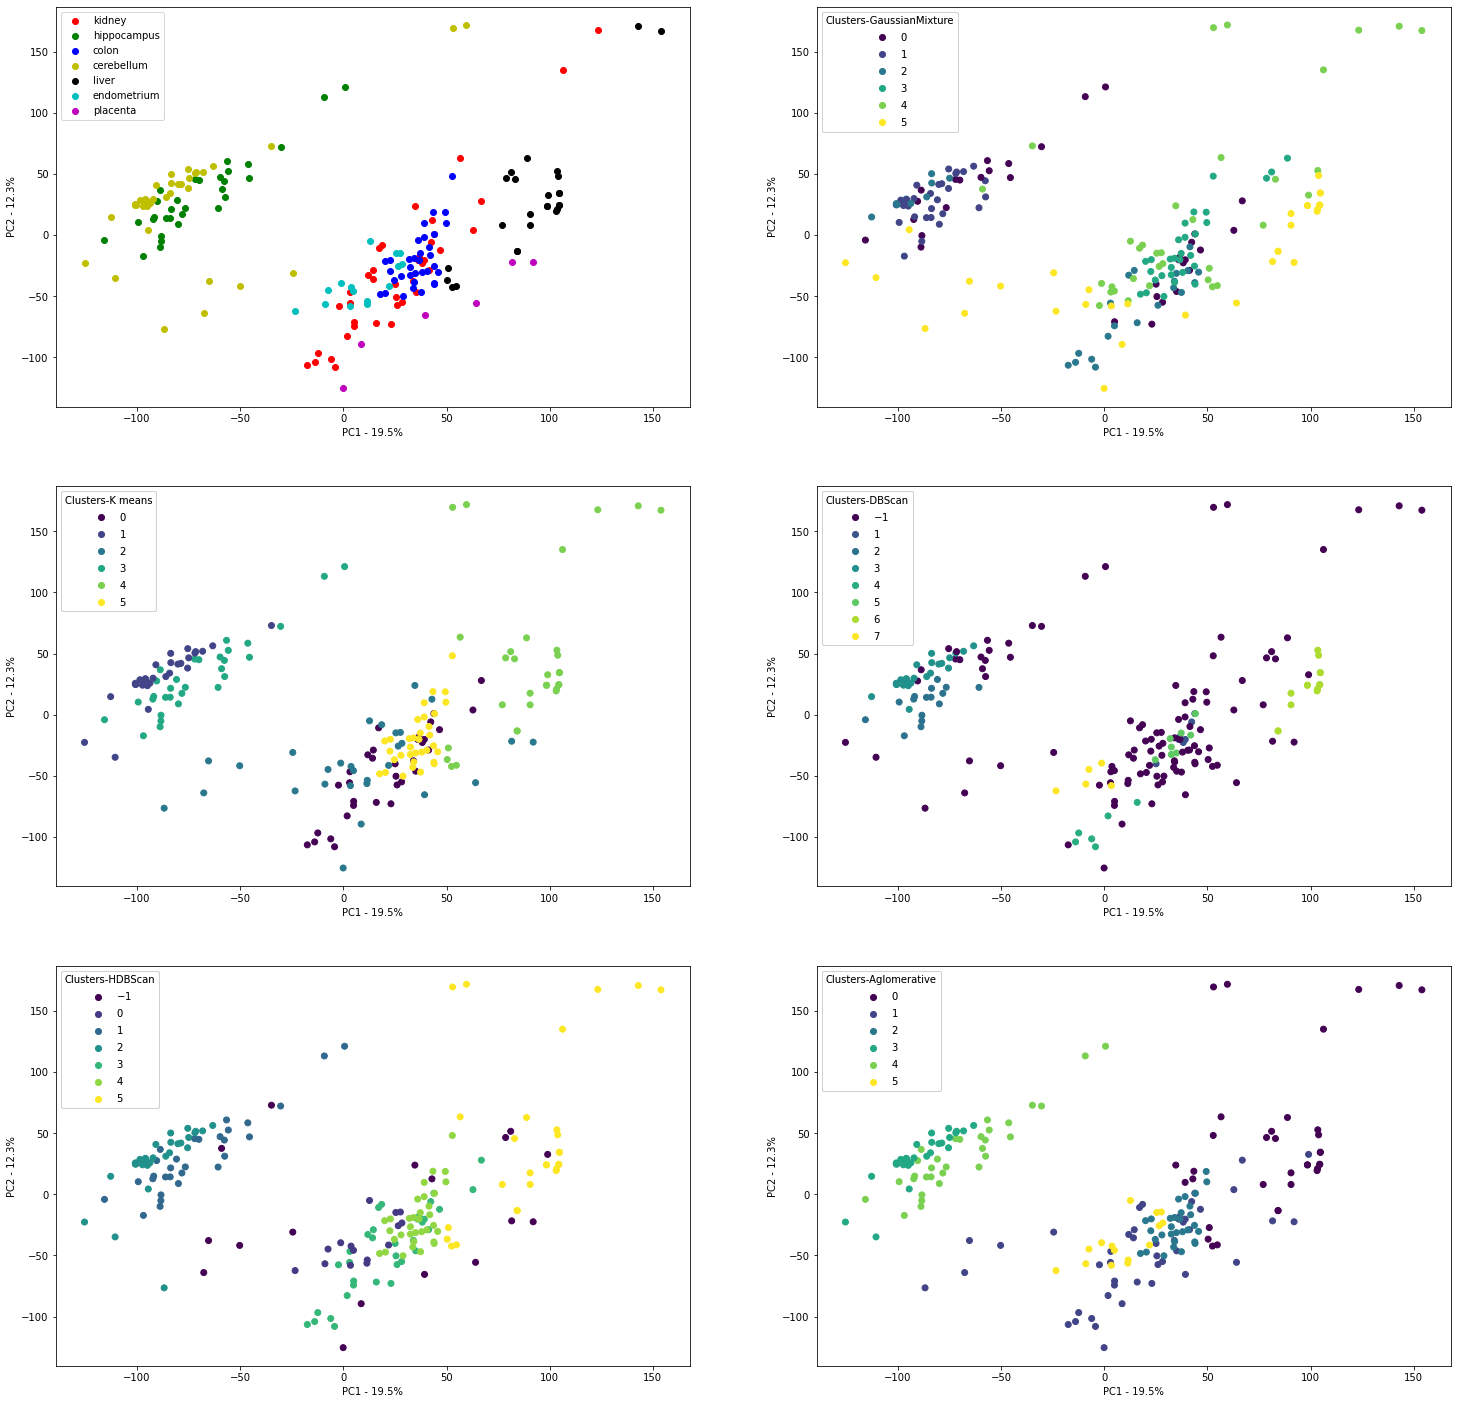

Para el tejido cerebellum empleando GaussianMixture el 47.37% pertenece al mismo clúster
Para el tejido cerebellum empleando K-Mean-Cluster el 81.58% pertenece al mismo clúster
Para el tejido cerebellum empleando DBSCAN el 68.42% pertenece al mismo clúster
Para el tejido cerebellum empleando HDBSCAN el 81.58% pertenece al mismo clúster
Para el tejido cerebellum empleando Aglomerative el 78.95% pertenece al mismo clúster
Para el tejido colon empleando GaussianMixture el 79.41% pertenece al mismo clúster
Para el tejido colon empleando K-Mean-Cluster el 100.00% pertenece al mismo clúster
Para el tejido colon empleando DBSCAN el 76.47% pertenece al mismo clúster
Para el tejido colon empleando HDBSCAN el 100.00% pertenece al mismo clúster
Para el tejido colon empleando Aglomerative el 91.18% pertenece al mismo clúster
Para el tejido endometrium empleando GaussianMixture el 66.67% pertenece al mismo clúster
Para el tejido endometrium empleando K-Mean-Cluster el 100.00% pertenece al mismo clú

In [20]:
df6,resumen6=evaluarClusters(df,clases,6)

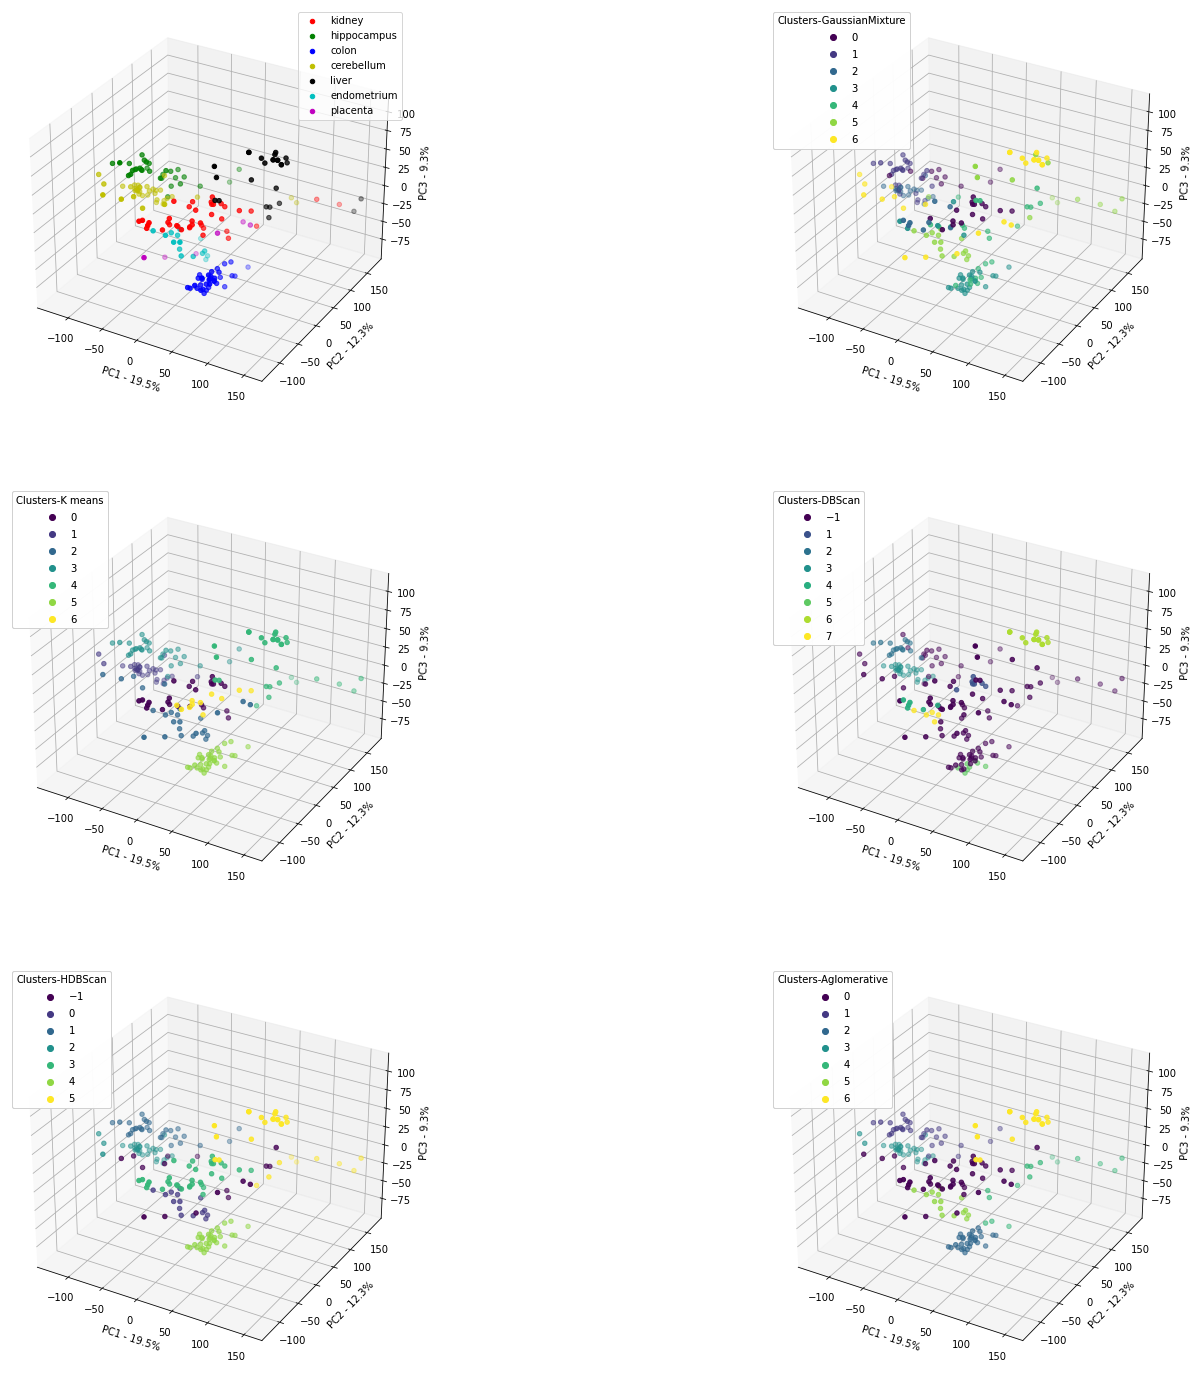

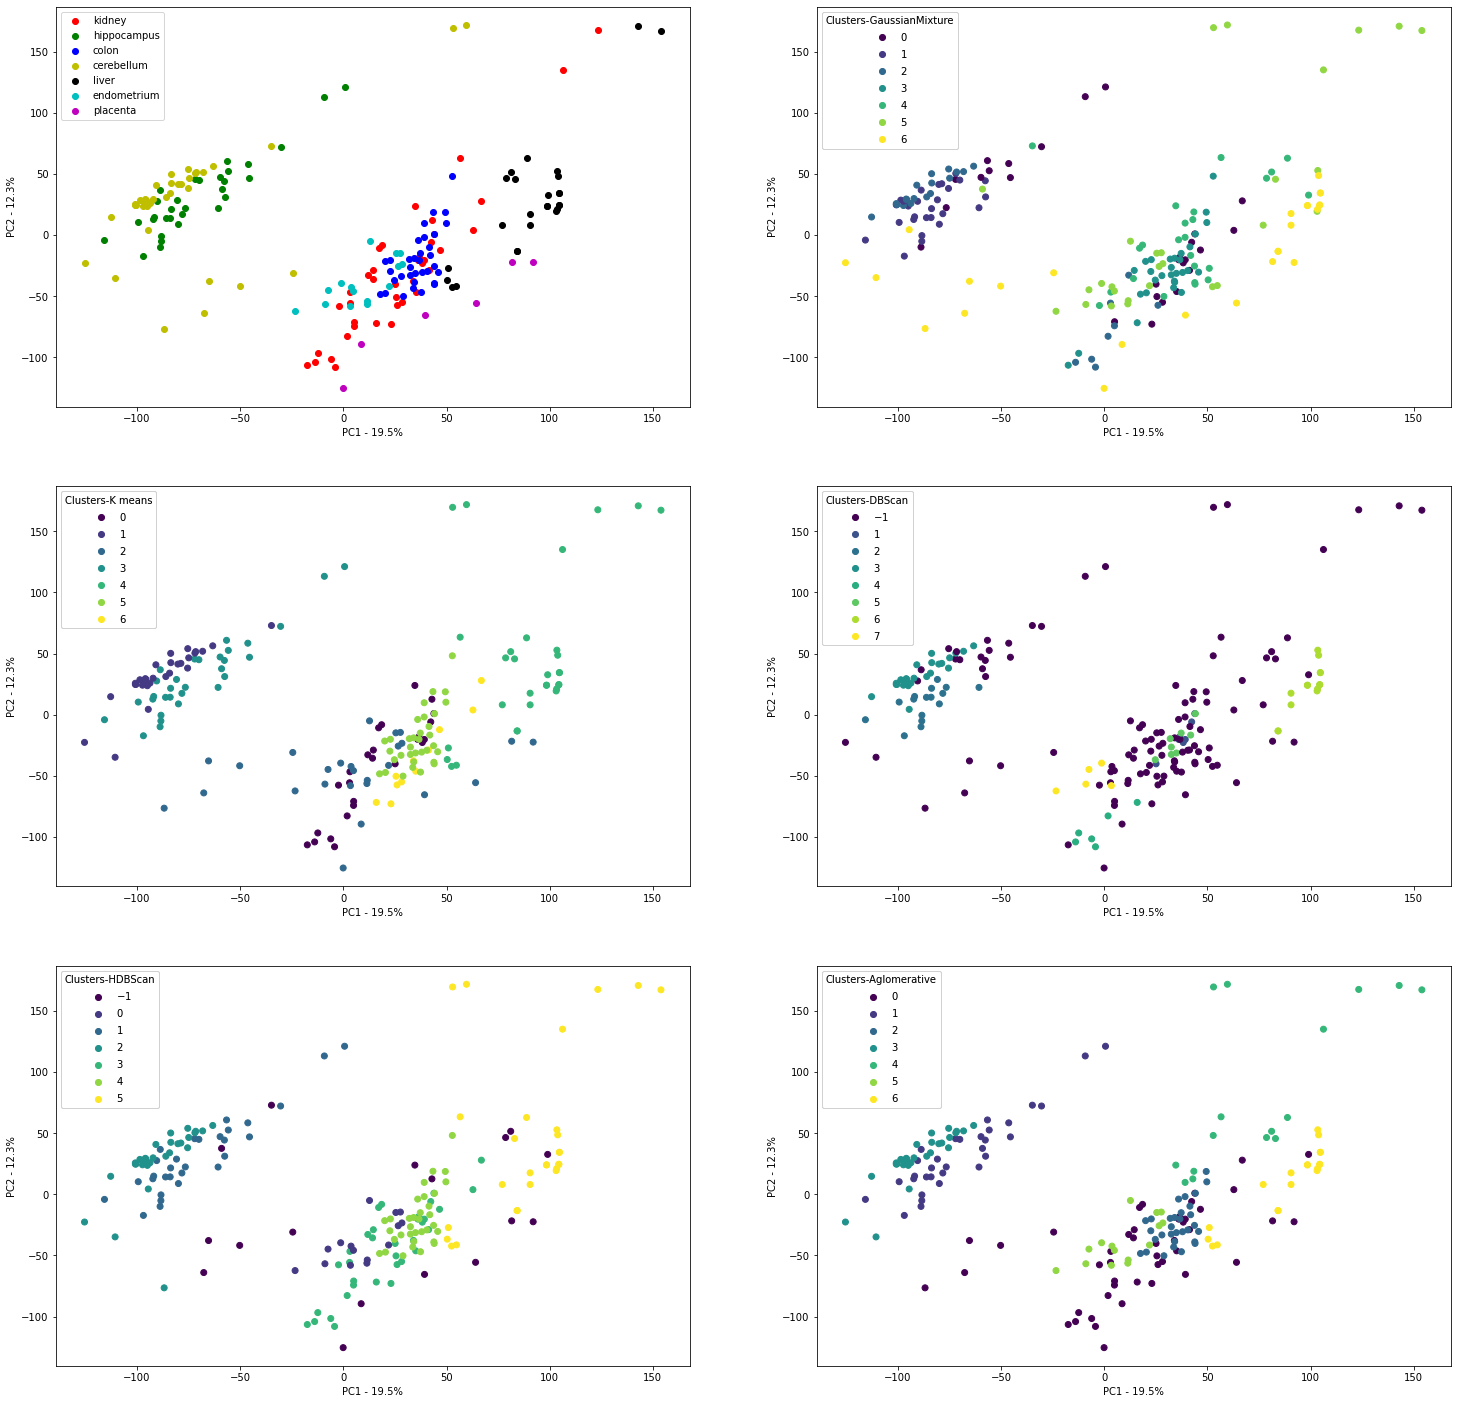

Para el tejido cerebellum empleando GaussianMixture el 47.37% pertenece al mismo clúster
Para el tejido cerebellum empleando K-Mean-Cluster el 81.58% pertenece al mismo clúster
Para el tejido cerebellum empleando DBSCAN el 68.42% pertenece al mismo clúster
Para el tejido cerebellum empleando HDBSCAN el 81.58% pertenece al mismo clúster
Para el tejido cerebellum empleando Aglomerative el 78.95% pertenece al mismo clúster
Para el tejido colon empleando GaussianMixture el 73.53% pertenece al mismo clúster
Para el tejido colon empleando K-Mean-Cluster el 100.00% pertenece al mismo clúster
Para el tejido colon empleando DBSCAN el 76.47% pertenece al mismo clúster
Para el tejido colon empleando HDBSCAN el 100.00% pertenece al mismo clúster
Para el tejido colon empleando Aglomerative el 91.18% pertenece al mismo clúster
Para el tejido endometrium empleando GaussianMixture el 100.00% pertenece al mismo clúster
Para el tejido endometrium empleando K-Mean-Cluster el 100.00% pertenece al mismo cl

In [33]:
df7,resumen7=evaluarClusters(df,clases,7)

In [22]:
### Resumen con el k=4
resumen4

,GaussianMixture,K-Mean-Cluster,DBSCAN,HDBSCAN,Aglomerative
cerebellum,81.58,92.11,68.42,81.58,78.95
colon,100.00,100.00,76.47,100.00,91.18
endometrium,100.00,100.00,66.67,100.00,100.00
hippocampus,100.00,100.00,51.61,96.77,100.00
kidney,92.31,84.62,66.67,87.18,100.00
liver,92.31,76.92,53.85,88.46,100.00
placenta,50.00,100.00,100.00,100.00,100.00


In [23]:
### Resumen con el k=5
resumen5

,GaussianMixture,K-Mean-Cluster,DBSCAN,HDBSCAN,Aglomerative
cerebellum,71.05,92.11,68.42,81.58,78.95
colon,100.00,100.00,76.47,100.00,91.18
endometrium,86.67,100.00,66.67,100.00,100.00
hippocampus,90.32,100.00,51.61,96.77,100.00
kidney,41.03,87.18,66.67,87.18,87.18
liver,53.85,100.00,53.85,88.46,96.15
placenta,100.00,66.67,100.00,100.00,100.00


In [24]:
### Resumen con el k=6
resumen6

,GaussianMixture,K-Mean-Cluster,DBSCAN,HDBSCAN,Aglomerative
cerebellum,47.37,81.58,68.42,81.58,78.95
colon,79.41,100.00,76.47,100.00,91.18
endometrium,66.67,100.00,66.67,100.00,100.00
hippocampus,54.84,100.00,51.61,96.77,100.00
kidney,41.03,84.62,66.67,87.18,87.18
liver,50.00,100.00,53.85,88.46,96.15
placenta,100.00,100.00,100.00,100.00,100.00


In [34]:
### Resumen con el k=7
resumen7

,GaussianMixture,K-Mean-Cluster,DBSCAN,HDBSCAN,Aglomerative
cerebellum,47.37,81.58,68.42,81.58,78.95
colon,73.53,100.00,76.47,100.00,91.18
endometrium,100.00,100.00,66.67,100.00,100.00
hippocampus,61.29,100.00,51.61,96.77,100.00
kidney,41.03,64.10,66.67,87.18,87.18
liver,46.15,100.00,53.85,88.46,73.08
placenta,100.00,100.00,100.00,100.00,100.00
